# Lac operon

In the main workshop notebook we have introduced a highly simplified model of the *lac* operon in *E. coli*, a gene circuit that allows cells to metabolise lactose in the absence of glucose. Here we consider a slightly different and expanded model of the *lac* operon, contrasting the deterministic and stochastic system dynamics of the system and investigating the time evolution of the probability distribution of the $Lac$ protein counts. This notebook is intended as a extra showcase of biological modelling in Julia and a playground for further model extensions that can (hopefully) serve as a useful exercise.

The *lac* operon contains two genes important for lactose metabolism:
* The *lacZ* gene encodes the β-galactosidase ($LacZ$) protein, which has two functions:
    * $LacZ$ catalyses the conversion of lactose $L$ into allolactose $A$
    * $LacZ$ catalyses the metabolisation of both lactose $L$ and allolactose $A$.
* The *lacY* gene encodes the β-galactoside permease protein ($LacY$), which catalyses the transport of lactose through the cell membrane.

Both of these genes are encoded on a single mRNA strand, which we will call $M$.

When glucose is abundant, the *lac* operon stays mostly transcriptionally inactive as the repressive transcription factor $LacI$ likes to bind to its promoter region. However, if glucose is not available but lactose is abundant, lactose metabolites such as allolactose can bind the repressor $LacI$ and deactivate it. The *lac* operon is freed from its inhibitor and can start transcribing. This triggers a positive feedback loop in the system, leading to high expression of the *lac* genes and enabling effective lactose digestion, which in turn produces more lactose metabolites that remove the inhibitory *lacI* repressor.

As before, we assume that the *lac* operon can be either on or off and allow switching between the two states. In the transcriptionally active (on) state, mRNA $M$ is transcribed at a rate $\rho_m$ and subsequently decays with a degradation rate $\delta_m$. We model the $LacZ$ and $LacY$ translation from the same mRNA transcript with the same rate $\rho_p$ due to their comparable kinetics, and assume that both proteins decay at a rate $\delta_p$.

In contrast to the previous model of the *lac* operon, here we do not induce the system by the IPTG but instead consider a time-varying extracellular concentration of lactose molecules explicitly. We assume that the rate of lactose uptake, catalysed by $LacY$, follows Michaelis-Menten kinetics:
$$ \frac{k_L \cdot L_e(t)}{K_{ML}+L_e(t)},$$
where $L_e(t)$ is the time-varying extracellular lactose concentration, while $k_L$ and $K_{ML}$ are the associated reaction parameters.

We assume that all reactions catalysed by $LacZ$ (conversion of $L$ into $A$, and the metabolisation of both $A$ and $L$) occur with the same rate given by a repressive Michaelis-Menten equation:
$$ \frac{k_A \cdot lacZ}{k_{MA} + lacZ}. $$

We do not explicitly model the repressor $LacI$ and the binding of allolactose $A$ to $LacI$ (this will be an exercise), and instead model allolactose $A$ as directly inducing transcription by modulating the gene inactivation rate:
$$ \frac{\sigma_{off} \cdot K_{off}}{K_{off}+A} .$$

In [2]:
using DifferentialEquations
using Catalyst
using Distributions
using Plots
using StatsBase

In [3]:
function sigmoid(x)
    return 1 / (1 + exp(-x))
end

# Extracellular lactose concentration as a time-dependent function
function lactose_conc(max_conc, t)
    return max_conc * sigmoid(10t - 60) * sigmoid(120 - 10t)
end

lactose_conc (generic function with 1 method)

Let us plot the extracellular lactose concentration over time:

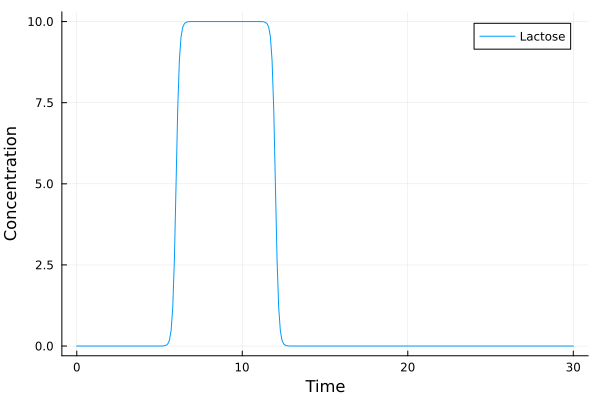

In [4]:
ts = 0:0.1:30.0
plot(ts, lactose_conc.(10.0, ts), xlabel="Time", ylabel="Concentration", label="Lactose")

Here is our reaction network defined in Catalyst.

In [5]:
rn = @reaction_network begin
    # lac repressor (LacI) binding switches the gene off, but allolactose A can bind the repressor
    # and inactivate it, making it unable to repress the gene promoter
    mmr(A, σ_off, K_off), G_on --> G_off    # Gene deactivation
    σ_on, G_off --> G_on                    # Gene activation

    ρ_m, G_on --> G_on + M            # mRNA transcription 
    δ_m, M --> 0                      # mRNA degradation

    ρ_p, M --> M + LacY              # LacY production (β-galactoside permease)
    ρ_p, M --> M + LacZ              # LacZ production (β-galactosidase)
    δ_p, LacZ --> 0                  # protein degradation for LacZ (β-galactosidase)
    δ_p, LacY --> 0                  # protein degradation for LacY (β-galactoside permease)

    mm(lactose_conc(max_conc, t), k_L, K_ML), LacY --> LacY + L # lactose uptake catalysed by LacY
    
    # lactose metabolism catalysed by β-galactosidase
    mm(LacZ, k_A, K_MA), L --> A      # conversion of lactose to allolactose (catalysed by LacZ)
    mm(LacZ, k_A, K_MA), L --> 0      # lactose metabolised into simpler sugars (catalysed by LacZ)
    mm(LacZ, k_A, K_MA), A --> 0      # allolactose metabolised into simpler sugars (catalysed by LacZ)
    δ_L, L --> 0                      # lactose dilution
    δ_L, A --> 0                      # allolactose dilution
end

Model ##ReactionSystem#237:
Unknowns (7): see unknowns(##ReactionSystem#237)
  G_on(t)
  G_off(t)
  M(t)
  LacY(t)
  LacZ(t)
  L(t)
  ⋮
Parameters (13): see parameters(##ReactionSystem#237)
  σ_off
  K_off
  σ_on
  ρ_m
  δ_m
  ρ_p
  ⋮

Here we set up the initial conditions and parameters. These are by no means biologically accurate; finding out more realistic values is a fantastic exercise in biological modelling.

In [6]:
p = [ # Telegraph switching rates
     :σ_on => 10,
     :σ_off => 200,
     :K_off => 0.01,

      # mRNA production & degradation rates
     :ρ_m => 5,             
     :δ_m => 2.0,
    
      # Protein production & degradation rates
     :ρ_p => 5,             
     :δ_p => 0.5,
    
     # Lactose uptake & degradation rates
     :k_L => 10.0, 
     :K_ML => 0.5,
     :δ_L => 0.2,
    
     # Lactose metabolisation & allolactose production
     :k_A => 10,
     :K_MA => 10,
     :max_conc => 10.0
]

# Initial condition
u0 = [ 
       :G_on => 0,
       :G_off => 1,
       :M => 0,
       :LacY => 0,
       :LacZ => 0,
       :L => 0,
       :A => 0
    ]

tmax = 30.0
tspan = (0, tmax)           # Time interval to solve on
ts = 0:0.1:tmax;            # Time points at which we record the system state

## Deterministic rate equations

We begin by considering the deterministic system behaviour and solving the resulting ODEs.

In [7]:
oprob = ODEProblem(rn, u0, tspan, p)
detsol = solve(oprob, saveat=ts);

We can plot the mRNA, Lactose and $LacZ$ dynamics, noting that the expression activity quickly rises as the extracellular lactose concentration is increased.

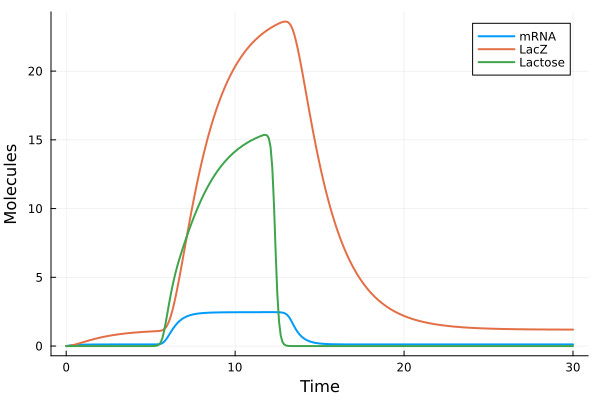

In [8]:
plot(detsol.t, detsol[:M], label="mRNA", lw=2, xlabel="Time", ylabel="Molecules")
plot!(detsol.t, detsol[:LacZ], label="LacZ", lw=2)
plot!(detsol.t, detsol[:L], label="Lactose", lw=2)

## Stochastic simulation

We can now proceed to generating stochastic trajectories of the system.

In [9]:
jinp = JumpInputs(rn, u0, tspan, p)
# By default, the system stores its state whenever a reaction happens. The `save_positions` argument
# overrides this to save a lot of memory.
jprob = JumpProblem(jinp, Direct(), save_positions=(false, false));         

In [10]:
sol = solve(jprob, Tsit5(), saveat=ts)

retcode: Success
Interpolation: 1st order linear
t: 3695-element Vector{Float64}:
  0.0
  0.04490695734043082
  0.04696780528161277
  0.1
  0.1479991867098044
  0.15275826111430327
  0.15325317011105788
  0.15977537568448183
  0.2
  0.3
  0.35274860582566575
  0.3528515276394637
  0.3650931767262996
  ⋮
 29.69180545016378
 29.692743807091507
 29.7
 29.720812841994224
 29.728620218452136
 29.8
 29.9
 29.9162419218811
 29.92117213473561
 29.95801664731708
 29.958705975887167
 30.0
u: 3695-element Vector{ExtendedJumpArray{Float64, 1, Vector{Float64}, Vector{Float64}}}:
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 0.0

In [ ]:
plot(sol.t, sol[:M], label="mRNA", lw=2, xlabel="Time", ylabel="Molecules", linetype=:steppost)
plot!(sol.t, sol[:LacZ], label="LacZ", lw=2, linetype=:steppost)
plot!(sol.t, sol[:L], label="Lactose", lw=2, linetype=:steppost)

Instead of having to code a `for` loop to run several simulations, we can utilise the [`EnsembleProblem`](https://docs.sciml.ai/DiffEqDocs/dev/features/ensemble/) implemented in DifferentialEquations, which allows us to generate a designated number of stochastic trajectories simply as follows:

In [14]:
ensembleprob = EnsembleProblem(jprob)
ensemble_sol = solve(ensembleprob, Tsit5(), trajectories=1000);

This might take a minute or two, but can be sped up eg. by using multi-threading (if you started Julia in multi-threaded mode).

Next we define a bunch of helper functions to automatically retrieve the means, variances and distributions for any chemical species in the system by parsing the obtained solution of the `EnsembleProblem` (`EnsembleSolution`). 

In [12]:
# Compute the mean over the ensemble trajectories for the given species at times ts
function get_mean(sol::EnsembleSolution, sym::Symbol, ts::AbstractVector)
    return [ mean(sol(t, idxs=sym)) for t in ts ]
end

# Compute the variance over the ensemble trajectories for the given species at times ts
function get_var(sol::EnsembleSolution, sym::Symbol, ts::AbstractVector)
    return [ var(sol(t, idxs=sym)) for t in ts ]
end;

# Fit histogram to a given array of discrete counts
function fit_hist(ys::AbstractVector)
    max_y = maximum(ys)
    ws = fit(Histogram, ys, 0:max_y+1, closed=:left)
    ws = FrequencyWeights(ws.weights)
    0:max_y, ws
end

# Compute the distribution over the ensemble trajectories for the given species at a time point t
function get_dist(sol::EnsembleSolution, sym::Symbol, t::Real)
    ys = sol(t, idxs=sym)
    return fit_hist(ys)
end

# Plot the distribution over the ensemble trajectories for the given species at a time point t
function plot_dist(sol::EnsembleSolution, sym::Symbol, t::Real; kwargs...)
    _, ws = get_dist(sol, sym, t)
    xmax = length(ws)
    xs = 0:xmax
    ys = ws ./ sum(ws)
    ys = vcat(ys, 0)
    plot(xs .- 0.5, zeros(xmax+1), linetype=:steppost, fillrange=ys; kwargs...)
end;

### Mean

Using the functions above, we can easily plot the time evolution of the mean molecule counts:

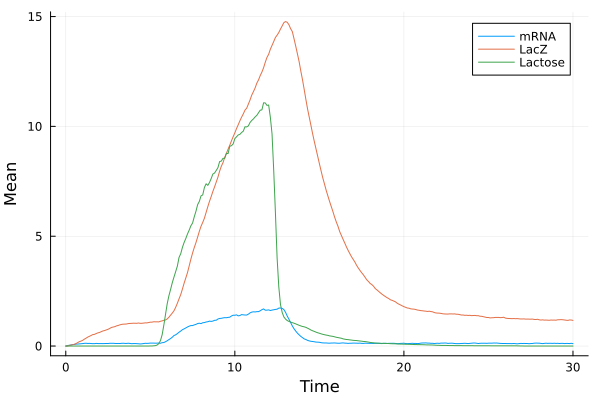

In [15]:
plot(ts, get_mean(ensemble_sol, :M, ts), label="mRNA", xlabel="Time", ylabel="Mean",)
plot!(ts, get_mean(ensemble_sol, :LacZ, ts), label="LacZ")
plot!(ts, get_mean(ensemble_sol, :L, ts), label="Lactose")

We can compare the obtained values to the deterministic predictions computed earlier:

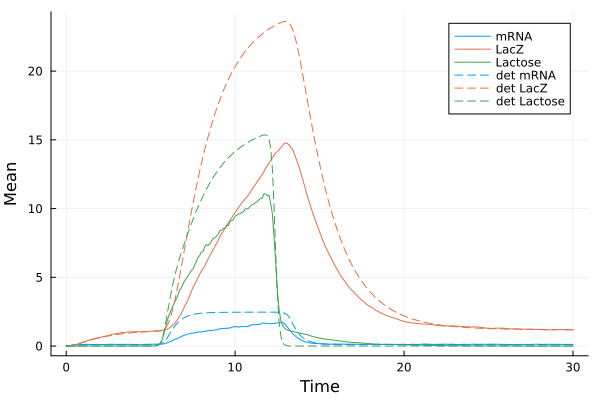

In [16]:
plot!(detsol.t, detsol[:M], label="det mRNA", linestyle=:dash, color=1)
plot!(detsol.t, detsol[:LacZ], label="det LacZ", linestyle=:dash, color=2)
plot!(detsol.t, detsol[:L], label="det Lactose", linestyle=:dash, color=3)

In this case, the means estimated by stochastic simulation are notably lower than their deterministic counterparts, indicating how taking into account the molecular noise can significantly alter the behaviour of a biochemical system.

### Variance

We can similarly plot how the variances of molecule counts change in time:

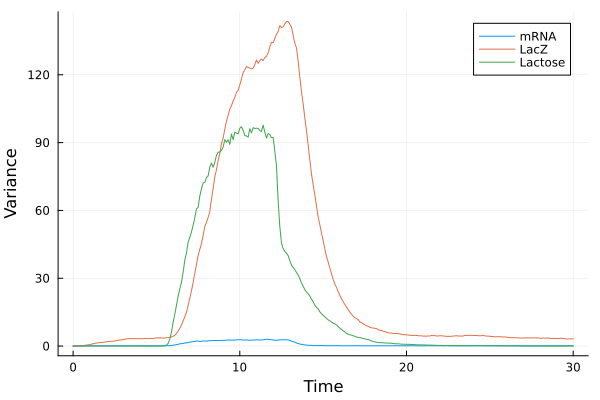

In [17]:
plot(ts, get_var(ensemble_sol, :M, ts), label="mRNA", xlabel="Time", ylabel="Variance")
plot!(ts, get_var(ensemble_sol, :LacZ, ts), label="LacZ")
plot!(ts, get_var(ensemble_sol, :L, ts), label="Lactose")

### Probability distribution

Here we plot a histogram of the number of *lacZ* molecules in the system at a fixed time $t = 5$. This illustrates the heterogeneity in cellular response - while most cells express very little *lacY* at that time, some are really active!

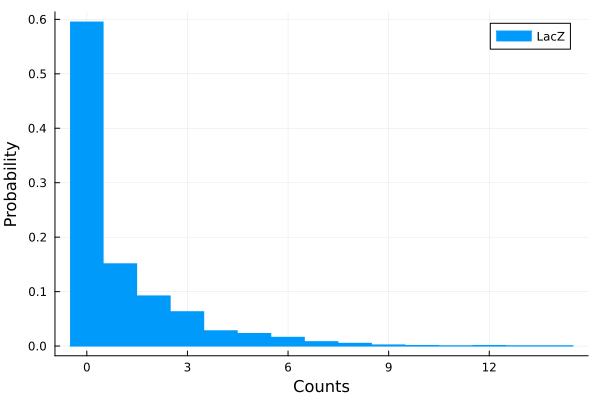

In [18]:
plot_dist(ensemble_sol, :LacZ, 5.0, xlabel="Counts", ylabel="Probability", label="LacZ")

And the same with the intracellular lactose abundance:

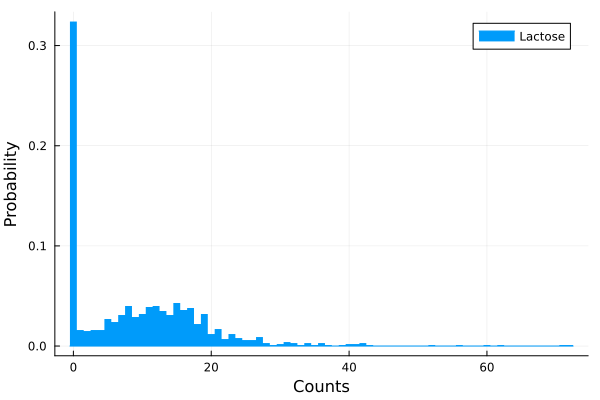

In [19]:
plot_dist(ensemble_sol, :L, 10.0, xlabel="Counts", ylabel="Probability", label="Lactose")

We combine multiple plots to visualise how the probability distribution of $LacZ$ protein changes as the time progresses, noting the appearance of transient bimodality at intermediate times:

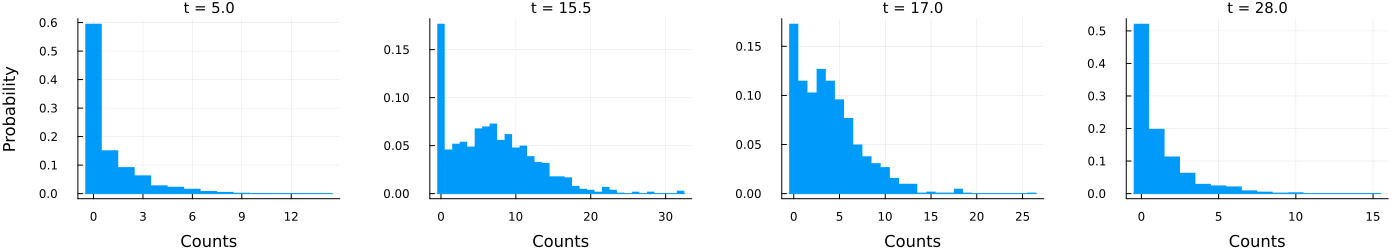

In [21]:
t1 = 5.0
pl1 = plot_dist(ensemble_sol, :LacZ, t1, label="", title="t = $t1", titlefontsize=10,
                xlabel="Counts", ylabel="Probability")
t2 = 15.5
pl2 = plot_dist(ensemble_sol, :LacZ, t2, label="", title="t = $t2", titlefontsize=10,
                xlabel="Counts", ylabel="")
t3 = 17.0
pl3 = plot_dist(ensemble_sol, :LacZ, t3, label="", title="t = $t3", titlefontsize=10,
                xlabel="Counts", ylabel="")
t4 = 28.0
pl4 = plot_dist(ensemble_sol, :LacZ, t4, label="", title="t = $t4", titlefontsize=10,
                xlabel="Counts", ylabel="")

plot(pl1, pl2, pl3, pl4, layout=(1, 4))
plot!(size=(1400,250), left_margin=7Plots.mm, bottom_margin=7Plots.mm)

## Exercises

* Try changing the parameter values and exploring the behaviour of *lac* operon. What parameter combinations would be more biologically realistic?
* How to incorporate more detailed repressor $LacI$ dynamics? Consider adding explicit reactions to model the binding of $LacI$ to the gene promoter, binding of allolactose $A$ to $LacI$, as well as its subsequent deactivation and hence induction of transcription. What parameters do you have to introduce here?
* Although we have treated the translation of $LacZ$ and $LacY$ as a single reaction, in reality, $LacZ$ is a tetramer composed of four monomers, whereas $LacY$ is a monomer. Try extending the model to add more realistic $LacZ$ construction, where the translated monomers form dimers that join to form the complete tetrameric $LacZ$ protein.  

You can use this notebook as a start to play around with the *lac* operon, and if you want you can make it even more detailed, further extending it by explicitly including lactose metabolism, and finding out how to tune the parameters in accordance with biological knowledge. Looking at the main notebook for this workshop, which of the aspects mentioned at the end (cell cycle, cell size, spatial structure etc.) do you think is the most important? How would you implement that in Catalyst (or your programming language or choice)? The world of whole-cell modelling is your oyster!